In [23]:
!pip install tensorflow

In [24]:
import os 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout ,Activation , Dense , LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
%matplotlib inline 


In [25]:
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=14,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [26]:
from google.colab import files
uploaded = files.upload()



Saving DOGE-USD-late.csv to DOGE-USD-late (1).csv


In [27]:
df = pd.read_csv('DOGE-USD-late.csv', parse_dates=['Date']) 

In [28]:
df=df.sort_values('Date')

In [29]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-01,0.002444,0.002559,0.002441,0.002494,0.002494,2.828870e+08
1,2020-05-02,0.002495,0.002553,0.002473,0.002549,0.002549,2.691553e+08
2,2020-05-03,0.002548,0.002583,0.002480,0.002510,0.002510,2.651569e+08
3,2020-05-04,0.002511,0.002519,0.002389,0.002481,0.002481,2.614543e+08
4,2020-05-05,0.002481,0.002521,0.002449,0.002484,0.002484,2.458611e+08
...,...,...,...,...,...,...,...
375,2021-05-11,0.450488,0.546651,0.445034,0.495231,0.495231,1.456698e+10
376,2021-05-12,0.493742,0.519975,0.385376,0.385376,0.385376,8.621338e+09
377,2021-05-13,0.392176,0.519461,0.357175,0.490374,0.490374,1.866317e+10
378,2021-05-14,0.487070,0.589690,0.464622,0.559604,0.559604,2.046618e+10


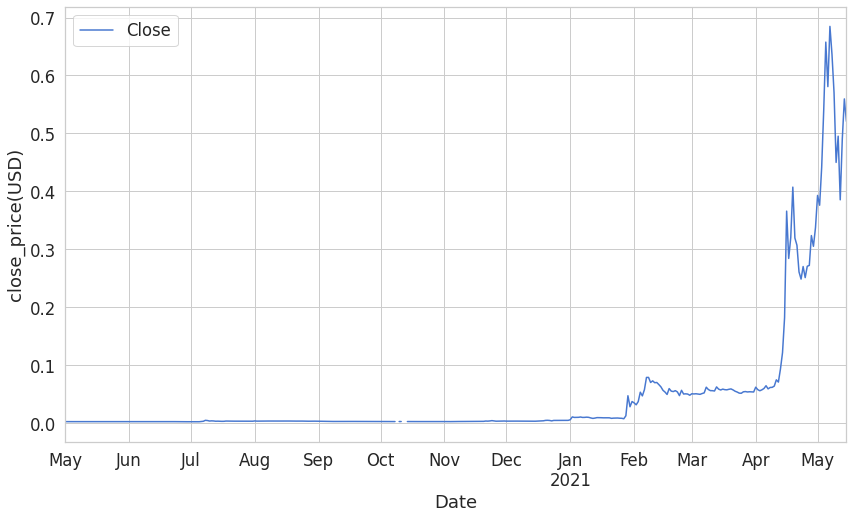

In [30]:
px = df.plot(x='Date',y='Close');
px.set_xlabel("Date")
px.set_ylabel("close_price(USD)");

YOU CAN SEE THAT PRICE OF DOGECOIN HAS PROGRESSED VERY UP AND UNTIL ELON MUSK **HOSTED** SNL

***DATA PREPERATION***

In [31]:
#NORMALIZATION
scaler=MinMaxScaler()
close_price = df.Close.values.reshape(-1,1)
scaled_close = scaler.fit_transform(close_price)

In [32]:
scaled_close.shape

(380, 1)

In [33]:
#to check whether any value is NAN or not funct will return false or true
np.isnan(scaled_close).any()

True

In [34]:
df.dropna()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-01,0.002444,0.002559,0.002441,0.002494,0.002494,2.828870e+08
1,2020-05-02,0.002495,0.002553,0.002473,0.002549,0.002549,2.691553e+08
2,2020-05-03,0.002548,0.002583,0.002480,0.002510,0.002510,2.651569e+08
3,2020-05-04,0.002511,0.002519,0.002389,0.002481,0.002481,2.614543e+08
4,2020-05-05,0.002481,0.002521,0.002449,0.002484,0.002484,2.458611e+08
...,...,...,...,...,...,...,...
375,2021-05-11,0.450488,0.546651,0.445034,0.495231,0.495231,1.456698e+10
376,2021-05-12,0.493742,0.519975,0.385376,0.385376,0.385376,8.621338e+09
377,2021-05-13,0.392176,0.519461,0.357175,0.490374,0.490374,1.866317e+10
378,2021-05-14,0.487070,0.589690,0.464622,0.559604,0.559604,2.046618e+10


PREPROCESSING

In [35]:
SEQ_LEN=100
def to_sequences(data, seq_len):
  d=[]
  for index in range(len(data)-seq_len):
    d.append(data[index: index + seq_len])

  return np.array(d)

def preprocess(data_raw, seq_len,train_split):
  data = to_sequences(data_raw, seq_len) 
  num_train = int(train_split*data.shape[0])
  
  X_train = data[:num_train,:-1,:] 
  y_train  = data[:num_train,-1,:]
  X_test  = data[num_train:,:-1,:]
  y_test  = data[num_train:,-1,:]
  return X_train ,y_train, X_test, y_test

X_train ,y_train, X_test, y_test=preprocess(scaled_close, SEQ_LEN,train_split=0.95) 

In [36]:
X_train.shape

(266, 99, 1)

In [37]:

y_train.shape


(266, 1)

In [38]:
X_test.shape


(14, 99, 1)

MODEL

In [39]:
DROPOUT=0.2
WINDOW_SIZE= SEQ_LEN-1
model = keras.Sequential()
model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE,return_sequences=True),input_shape=(WINDOW_SIZE,X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE*2),return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE,return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))


In [40]:
#TRAINING
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [41]:
BATCH_SIZE = 64
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
4/4 [==============================] - 4s 362ms/step - loss: nan - val_loss: nan
Epoch 2/50
4/4 [==============================] - 0s 54ms/step - loss: nan - val_loss: nan
Epoch 3/50
4/4 [==============================] - 0s 58ms/step - loss: nan - val_loss: nan
Epoch 4/50
4/4 [==============================] - 0s 55ms/step - loss: nan - val_loss: nan
Epoch 5/50
4/4 [==============================] - 0s 54ms/step - loss: nan - val_loss: nan
Epoch 6/50
4/4 [==============================] - 0s 56ms/step - loss: nan - val_loss: nan
Epoch 7/50
4/4 [==============================] - 0s 55ms/step - loss: nan - val_loss: nan
Epoch 8/50
4/4 [==============================] - 0s 55ms/step - loss: nan - val_loss: nan
Epoch 9/50
4/4 [==============================] - 0s 58ms/step - loss: nan - val_loss: nan
Epoch 10/50
4/4 [==============================] - 0s 57ms/step - loss: nan - val_loss: nan
Epoch 11/50
4/4 [==============================] - 0s 54ms/step - loss: nan - val_loss: 

In [42]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 86ms/step - loss: nan


nan

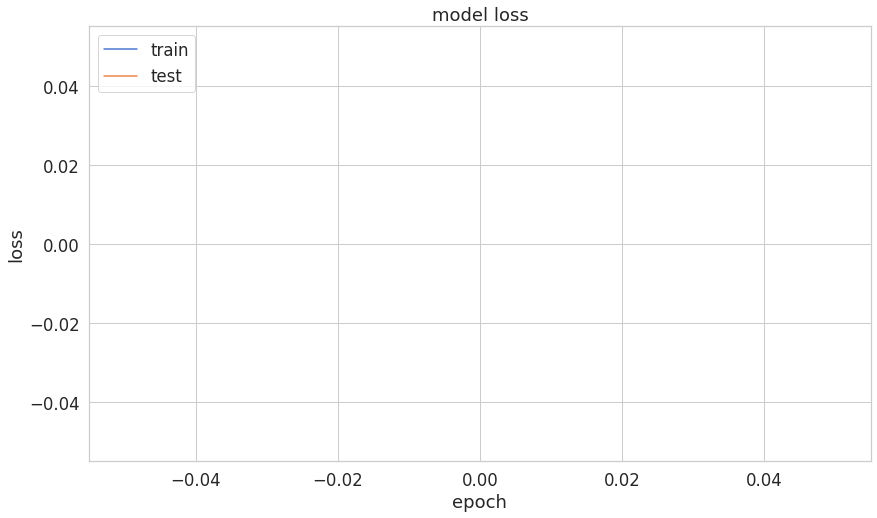

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

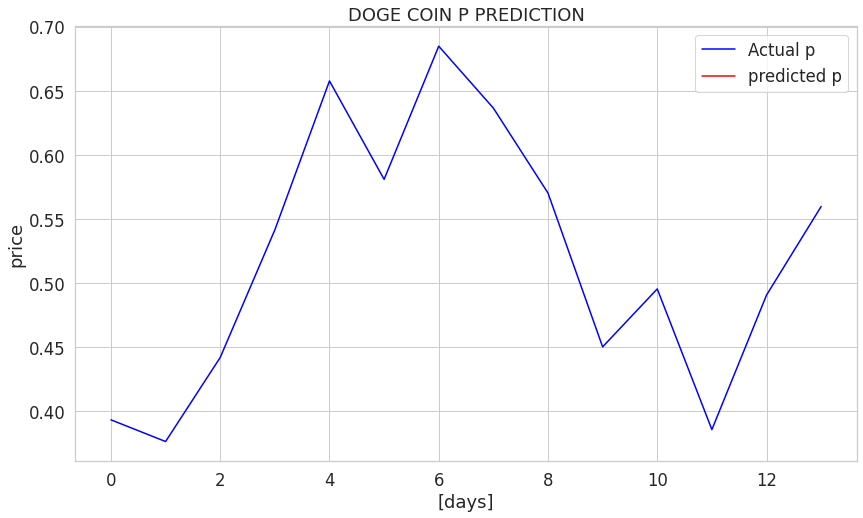

In [44]:
#PREDICTION
y_hat=model.predict(X_test)
y_test_inv=scaler.inverse_transform(y_test)
y_hat_inv= scaler.inverse_transform(y_hat)
plt.plot(y_test_inv,label="Actual p",color='blue')
plt.plot(y_hat_inv,label="predicted p",color='red')
plt.title('DOGE COIN P PREDICTION')
plt.xlabel('[days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show();